In [1]:
import fastai
from fastai.vision import *

In [11]:
path = Path("/home/jupyter/fai-berlin-faces/cropped/")


In [12]:
verify_images(path, recurse=True)

In [13]:
path

PosixPath('/home/jupyter/fai-berlin-faces/cropped')

In [83]:
fn = [x for x in path.iterdir()][:5]
fn

[PosixPath('/home/jupyter/fai-berlin-faces/cropped/2_1_2_20161219212017166.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/63_0_0_20170111201901467.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/33_1_3_20170104223525079.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/49_1_0_20170104235655316.jpg.chip.jpg'),
 PosixPath('/home/jupyter/fai-berlin-faces/cropped/25_1_0_20170103182309849.jpg.chip.jpg')]

## Label Fns 
We should also try multilabel and a loss function that combines age / gender / ethnicity

In [88]:
def isFemale(path):
   # print(path, "path here")
    return bool(int(path.name.split('_')[1]))

[isFemale(p) for p in fn]

[True, False, True, True, True]

In [87]:
#seems to bee no file_name issues
for p in path.iterdir():
    try:
        print(p.name.split('_')[1])
    except: 
        print(p) 


1
0
1
1
1
0
1
1
1
0
0
1
0
0
0
0
0
1
1
0
0
1
1
1
1
0
1
1
1
1
0
1
0
0
0
1
1
0
1
1
1
1
1
0
1
0
1
1
1
1
1
0
0
0
1
1
1
0
0
0
1
0
0
1
1
1
0
1
1
0
0
1
0
0
0
0
1
1
0
1
0
0
1
1
0
0
0
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
1
0
1
1
1
0
1
1
1
1
0
1
0
0
1
1
0
1
1
0
0
1
0
1
1
1
0
1
1
1
0
1
1
0
0
0
0
0
1
0
0
0
0
1
0
1
0
1
1
1
0
1
0
0
1
0
0
1
0
0
1
1
1
1
1
0
0
0
1
0
1
1
1
1
0
0
1
1
0
1
1
1
1
0
0
0
1
1
1
1
0
1
1
1
0
0
1
1
1
1
0
1
0
1
0
0
0
0
0
0
0
1
0
1
1
0
1
1
1
0
1
1
1
1
1
1
0
1
1
0
0
1
0
1
0
1
0
1
1
0
1
0
0
1
0
1
0
1
1
0
0
1
1
0
1
1
1
0
1
0
1
0
1
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
0
1
1
1
1
1
0
1
1
0
0
1
0
0
1
1
0
0
1
0
1
0
0
1
1
0
1
1
0
1
1
0
1
0
1
1
1
0
0
1
1
1
1
0
1
1
1
1
1
1
0
1
0
0
0
0
0
0
1
1
0
1
0
1
0
0
1
1
0
1
1
0
0
1
0
1
0
1
1
1
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
1
0
0
0
1
1
0
1
1
0
0
0
0
1
0
0
1
0
0
1
0
1
1
0
1
1
1
1
0
1
1
1
1
1
0
0
0
0
1
1
0
1
0
1
1
1
0
1
1
1
1
0
1
1
1
1
0
0
0
0
1
0
1
0
0
0
0
0
1
0
0
0
1
0
1
1
1
0
1
0
1
1
1
1
1
0
0
0
0
1
0
0
1
0
1
1
1
0
0
0
0
1
1
1
1


0
1
0
1
1
0
0
0
0
1
1
1
1
1
1
0
1
1
1
1
0
1
0
1
0
0
1
0
0
1
1
0
0
0
1
0
0
0
0
1
0
1
1
1
0
1
1
0
1
1
0
0
1
1
0
1
1
0
1
1
0
0
0
1
1
0
0
1
1
0
1
0
1
0
0
1
1
1
0
1
0
1
0
1
1
0
0
0
0
0
1
1
0
0
0
0
1
1
1
1
0
1
1
1
0
1
0
0
1
1
1
0
1
0
0
1
1
1
1
0
0
1
0
0
0
0
1
0
0
0
1
0
1
0
1
1
0
1
0
0
0
0
1
0
1
1
1
0
0
1
0
1
0
0
1
1
1
1
1
1
0
0
0
1
0
1
0
1
0
1
0
0
1
1
1
0
1
0
1
1
1
1
1
0
1
0
0
1
0
0
1
0
1
1
0
0
0
1
0
0
1
0
1
1
0
1
1
1
0
1
1
1
0
0
0
0
0
1
0
0
1
0
1
1
0
1
0
1
0
0
0
1
1
0
0
1
0
1
1
1
0
1
0
0
0
1
0
1
1
0
0
0
0
1
0
0
0
1
0
0
1
1
1
1
1
1
0
0
1
0
1
1
1
0
1
0
1
1
0
0
0
1
1
0
0
0
1
0
0
1
0
1
1
1
0
1
1
1
1
1
0
1
1
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
1
1
1
0
0
1
1
0
0
0
1
1
1
1
1
1
1
0
0
0
1
1
1
1
0
0
0
0
0
0
1
1
0
1
0
1
1
0
1
0
0
0
0
1
1
1
1
0
1
0
0
0
1
1
1
1
0
1
1
0
0
1
1
0
0
0
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
1
0
1
0
0
1
0
0
0
0
1
0
1
1
1
1
1
0
0
1
0
0
0
1
0
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
1
1
0
1
0
1
0
1
1
0
1
0
0
1
0
1
1
0
1
0
0
1
0
0
1
0
1
1
0
1
1
1
0
0
0
1
0
0
0
1
1
0
0
1
0
0
1
1
1
1
1
1
1
1
0
1
1
0
1
0


0
1
1
1
1
1
1
1
1
0
1
1
0
1
1
0
0
1
1
1
0
1
0
1
1
1
0
0
0
1
1
0
0
1
0
0
1
1
1
0
0
1
1
0
1
1
0
1
0
0
1
0
0
0
1
0
0
0
1
1
0
1
0
0
1
0
0
0
1
0
1
1
1
1
0
1
1
0
0
1
0
1
1
1
1
1
0
0
0
0
0
0
1
0
1
0
0
1
0
1
0
0
1
1
1
1
0
0
1
1
0
0
1
0
0
0
0
0
0
0
1
0
1
1
1
1
1
0
1
1
1
0
0
0
1
0
1
0
0
1
0
1
0
0
1
1
0
1
0
1
0
1
1
1
0
1
0
1
1
0
0
1
1
1
1
1
0
1
0
1
1
0
0
0
0
1
1
1
0
1
1
1
1
1
0
0
0
0
0
1
1
0
1
1
1
1
1
0
0
1
0
1
0
1
1
0
0
1
1
1
1
0
0
0
0
0
0
0
1
1
1
1
1
1
0
1
0
0
1
1
0
0
0
0
1
1
1
1
0
0
0
1
1
0
1
1
1
1
1
1
0
0
1
1
1
0
1
1
0
0
0
1
0
1
0
0
1
1
1
0
1
0
1
0
1
0
1
0
0
1
1
0
0
0
1
0
1
0
1
1
1
1
0
0
1
0
0
1
0
1
1
0
1
1
1
1
1
1
1
0
0
0
1
1
1
1
1
0
0
1
0
1
1
0
0
0
0
1
0
1
0
0
1
1
0
1
1
1
0
1
1
1
1
0
1
1
1
1
0
0
0
1
1
1
1
0
0
1
1
1
0
0
1
0
0
1
1
0
0
1
1
1
1
1
0
0
1
1
1
0
1
1
1
1
0
1
1
0
0
1
1
1
1
1
0
1
1
1
0
0
1
1
0
1
0
1
1
1
0
1
1
0
1
1
1
1
1
1
0
1
1
1
0
0
1
0
0
1
0
0
0
1
1
0
0
1
1
1
1
1
1
0
0
1
0
1
1
1
1
1
0
1
1
0
1
0
1
1
0
0
0
0
1
1
1
1
0
1
0
1
0
0
0
0
0
0
1
1
1
0
1
0
1
1
1
1
0
1
0


## Classify Age without Augmentation

In [46]:
tfms = []
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(lambda p: "female" if isFemale(p) else "male") \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [48]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.796173,0.505408,0.789366,00:22
1,0.520279,0.439838,0.809305,00:22


In [49]:
learner.unfreeze()

In [53]:
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.438373,0.356544,0.832311,00:29
1,0.276928,0.273762,0.882413,00:28


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


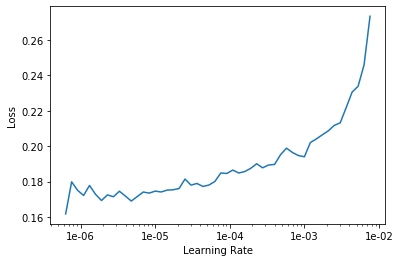

In [54]:
learner.lr_find()
learner.recorder.plot()

1847 misclassified samples over 1956 samples in the validation set.


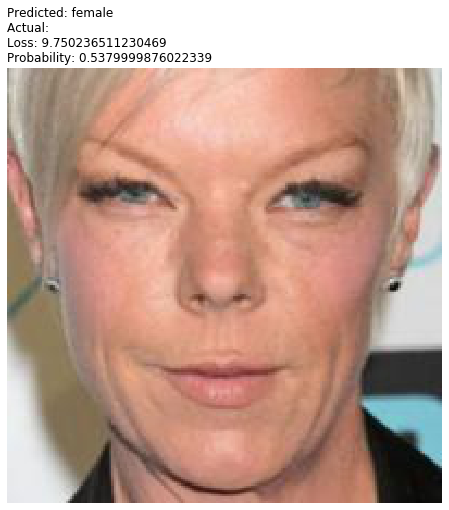

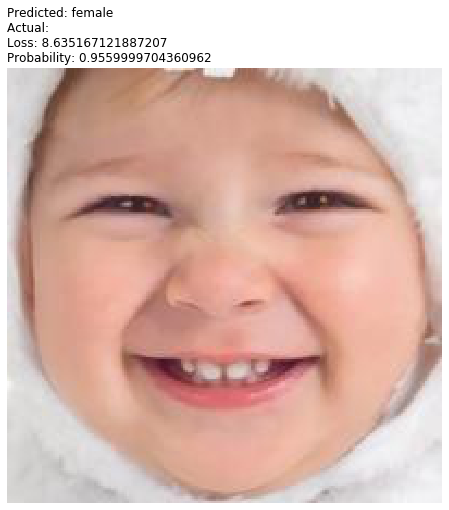

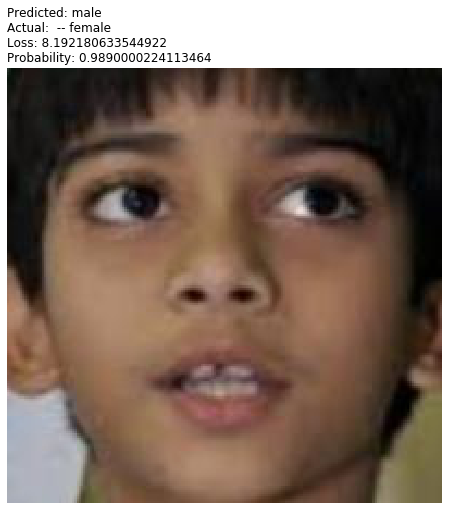

In [90]:
#did they change that API ? It was easier previously
'''
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
'''
interp = learner.interpret()
interp.top_losses()
interp.plot_multi_top_losses()

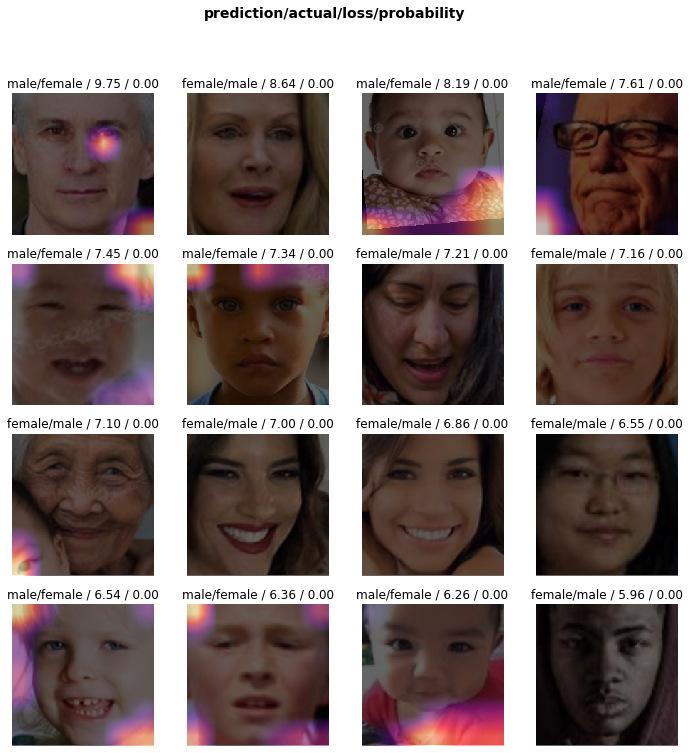

In [92]:
interp.plot_top_losses(16, heatmap=True)

## Age with Augmentation

In [57]:
tfms = get_transforms(max_rotate=25); 
len(tfms[0]), len(tfms)

(7, 2)

In [58]:
data = ( ImageList.from_folder(path) \
           # .filter_by_func() \
            .split_by_rand_pct(0.2) \
            .label_from_func(lambda p: "female" if isFemale(p) else "male") \
            .transform(tfms)\
            .databunch() \
            .normalize() )

In [59]:
l2 = cnn_learner(data, models.resnet18, metrics=[accuracy])
l2.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.853683,0.521144,0.768916,00:23
1,0.631068,0.440755,0.794990,00:24


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


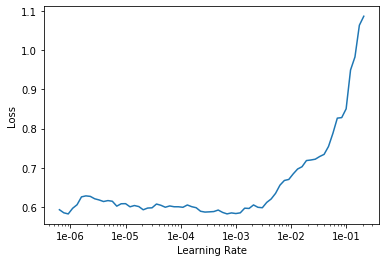

In [60]:
l2.unfreeze()
l2.lr_find()
l2.recorder.plot()

In [61]:
learner.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.321486,0.474436,0.789877,00:29
1,0.222009,0.268371,0.888548,00:29


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


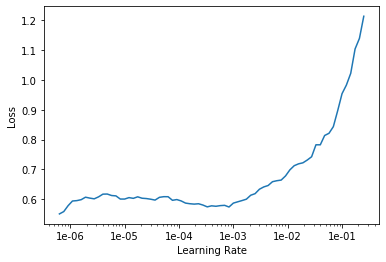

In [63]:
learner.freeze_to(-2)
l2.lr_find()
l2.recorder.plot()

In [64]:
learner.fit_one_cycle(2,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.124705,0.305285,0.888037,00:25
1,0.084547,0.333770,0.884969,00:25


## Ethnicity 